In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer

# estudo árvores
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance

from lightgbm import LGBMClassifier

from src.config import DADOS_LIMPOS
from src.graficos import plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette='viridis_r')

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [3]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]


In [4]:
# Label encoding for binary classification
le = LabelEncoder()

y = le.fit_transform(y)


In [5]:
# Feature selection (15 best via Mutual Information)
seletor_mi = SelectKBest(mutual_info_classif, k=15)

X_mi = seletor_mi.fit_transform(X, y)

X_mi.shape


(569, 15)

In [6]:
seletor_mi.get_feature_names_out()

array(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_worst', 'concave points_mean', 'concave points_worst',
       'concavity_mean', 'concavity_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst'], dtype=object)

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [8]:
preprocessamento = Pipeline(
    steps=[
        ("scaler", PowerTransformer()),
        ("selector", SelectKBest(mutual_info_classif, k=15))
    ]
)

preprocessamento_arvore = Pipeline(
    steps=[
        ("selector", SelectKBest(mutual_info_classif, k=15))
    ]
)


In [9]:
# hiperparâmetros usados com base nos melhores resultados encontrados em teste anterior
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified")
    },
    
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(
            C= 0.1,
            class_weight= 'balanced',
            penalty= 'l2',
            solver= 'liblinear'
        )
    },
    "SGDClassifier": {
        "preprocessor": preprocessamento,
        "classificador": SGDClassifier()
    },
    
    # adicionar modelos baseados em árvores de decisão
    
    "RandomForestClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "XGBClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "LGBMClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
}


In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
0,DummyClassifier,0.005064,0.02819,0.5,0.470193,0.344828,0.340909,0.348837,0.488863,0.372149,0.347222,0.033253
1,DummyClassifier,0.003035,0.020319,0.482456,0.437766,0.271605,0.289474,0.255814,0.468064,0.363933,0.261905,0.023353
2,DummyClassifier,0.001151,0.01784,0.605263,0.578373,0.470588,0.465116,0.47619,0.453373,0.350191,0.473934,0.018991
3,DummyClassifier,0.002793,0.009638,0.491228,0.463294,0.340909,0.326087,0.357143,0.436508,0.3458,0.350467,0.012431
4,DummyClassifier,0.0,0.018704,0.60177,0.576123,0.470588,0.465116,0.47619,0.543092,0.394545,0.473934,0.018704
5,LogisticRegression,0.182653,0.021721,0.929825,0.943662,0.914894,0.843137,1.0,0.998362,0.997228,0.964126,0.204374
6,LogisticRegression,0.200135,0.020402,0.947368,0.94399,0.930233,0.930233,0.930233,0.987553,0.982188,0.930233,0.220537
7,LogisticRegression,0.180922,0.020058,0.921053,0.917659,0.894118,0.883721,0.904762,0.978836,0.973175,0.900474,0.20098
8,LogisticRegression,0.19002,0.019939,0.903509,0.918651,0.88172,0.803922,0.97619,0.988095,0.981961,0.936073,0.209959
9,LogisticRegression,0.21174,0.030187,0.964602,0.962106,0.952381,0.952381,0.952381,0.99497,0.992817,0.952381,0.241927


In [11]:
df_resultados.groupby("model").mean().sort_values("test_f2_score")


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
model,,,,,,,,,,,
DummyClassifier,0.002409,0.018938,0.536143,0.50515,0.379704,0.37734,0.382835,0.47798,0.365324,0.381492,0.021346
RandomForestClassifier,0.427988,0.087113,0.942028,0.934762,0.919985,0.939632,0.905869,0.98843,0.983118,0.910894,0.515101
SGDClassifier,0.24138,0.02643,0.93855,0.932826,0.917207,0.925043,0.91041,0.986644,0.98323,0.913008,0.26781
LGBMClassifier,0.578032,0.020779,0.943782,0.936827,0.923299,0.938601,0.910078,0.986523,0.980717,0.915137,0.59881
XGBClassifier,0.306401,0.022351,0.943798,0.936937,0.923296,0.937844,0.910299,0.986718,0.981171,0.915321,0.328752
LogisticRegression,0.193094,0.022461,0.933271,0.937213,0.914669,0.882679,0.952713,0.989563,0.985474,0.936657,0.215555


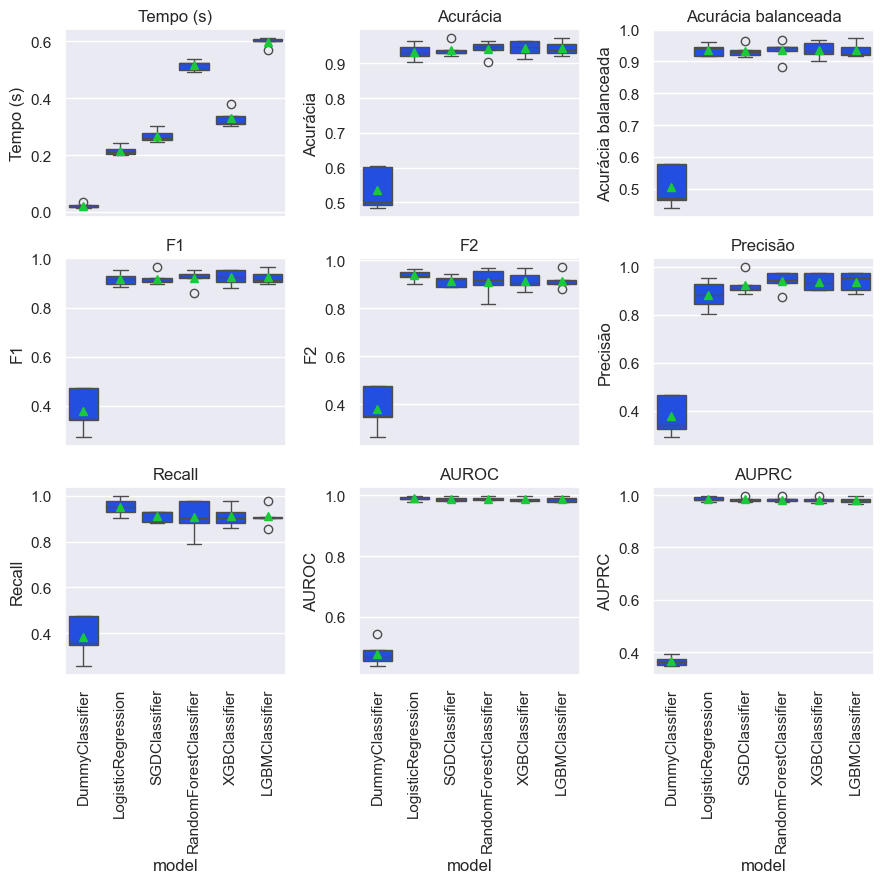

In [12]:
plot_comparar_metricas_modelos(df_resultados)

In [13]:
np.bincount(y)

array([357, 212], dtype=int64)

In [14]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight


1.6839622641509433

In [15]:
# param grid para o modelo em estudo
param_grid = {
    "clf__max_depth": [3, 6, 10],  # Profundidade da árvore
    "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    "clf__learning_rate": [0.1, 0.3, 0.5],  # Taxa de aprendizado
    "clf__n_estimators": [10, 30],  # Número de árvores
    "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1
    "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes
}


In [16]:
# classificador baseado em árvore de decisão
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento_arvore, refit_metric="f2_score"
)

grid_search


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('selector',
                                                         SelectKBest(k=15,
                                                                     score_func=<function mutual_info_classif at 0x000001B6AC8F58A0>))])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytr...
                         'clf__scale_pos_weight': [1, 1.6839622641509433],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [17]:
grid_search.fit(X, y)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('selector',
                                                         SelectKBest(k=15,
                                                                     score_func=<function mutual_info_classif at 0x000001B6AC8F58A0>))])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytr...
                         'clf__scale_pos_weight': [1, 1.6839622641509433],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [18]:
grid_search.best_params_

{'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 6,
 'clf__n_estimators': 30,
 'clf__reg_alpha': 0.5,
 'clf__reg_lambda': 5,
 'clf__scale_pos_weight': 1.6839622641509433,
 'clf__subsample': 0.6}

In [19]:
grid_search.best_score_

0.9483336323806097

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('selector',
                                  SelectKBest(k=15,
                                              score_func=<function mutual_info_classif at 0x000001B6AC8F58A0>))])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [21]:
grid_search.best_estimator_["preprocessor"].get_feature_names_out()

array(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_worst', 'concave points_mean', 'concave points_worst',
       'concavity_mean', 'concavity_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst'], dtype=object)

In [22]:
# Obter as importâncias das features
feature_importances = grid_search.best_estimator_["clf"].get_booster().get_score(importance_type="weight")

feature_importances

{'f0': 8.0,
 'f1': 20.0,
 'f2': 17.0,
 'f3': 17.0,
 'f4': 9.0,
 'f5': 19.0,
 'f6': 27.0,
 'f7': 14.0,
 'f8': 26.0,
 'f9': 7.0,
 'f10': 10.0,
 'f11': 18.0,
 'f12': 2.0,
 'f13': 14.0,
 'f14': 15.0}

In [23]:
# Ordenar as features por importância
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

sorted_features

[('f12', 2.0),
 ('f9', 7.0),
 ('f0', 8.0),
 ('f4', 9.0),
 ('f10', 10.0),
 ('f7', 14.0),
 ('f13', 14.0),
 ('f14', 15.0),
 ('f2', 17.0),
 ('f3', 17.0),
 ('f11', 18.0),
 ('f5', 19.0),
 ('f1', 20.0),
 ('f8', 26.0),
 ('f6', 27.0)]

In [24]:
# Extrair os índices ordenados
indices_ordenados_weight = [int(item[0].replace("f", "")) for item in sorted_features]
indices_ordenados_weight

[12, 9, 0, 4, 10, 7, 13, 14, 2, 3, 11, 5, 1, 8, 6]

In [25]:
# Obter os nomes das features ordenadas
feature_names = grid_search.best_estimator_["preprocessor"].get_feature_names_out()[indices_ordenados_weight]
feature_names

array(['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_worst',
       'perimeter_se', 'concavity_mean', 'radius_se', 'radius_worst',
       'area_worst', 'compactness_mean', 'perimeter_worst',
       'concave points_mean', 'area_se', 'concavity_worst',
       'concave points_worst'], dtype=object)

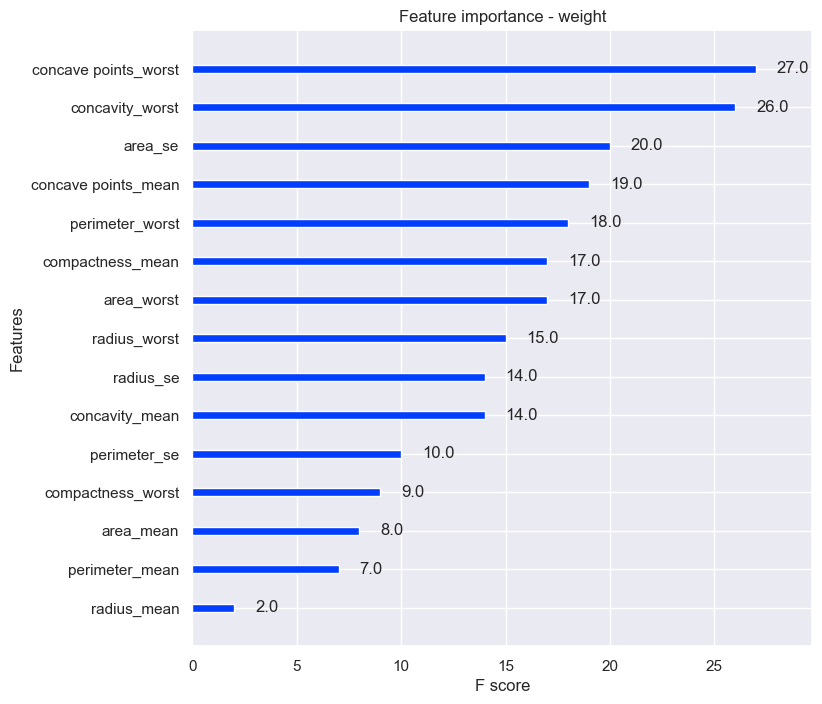

In [26]:
#Importância das features
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    title="Feature importance - weight"
)

# Ajustar os rótulos do eixo y
plt.yticks(
    np.arange(len(feature_names)),
    feature_names
)

plt.show()

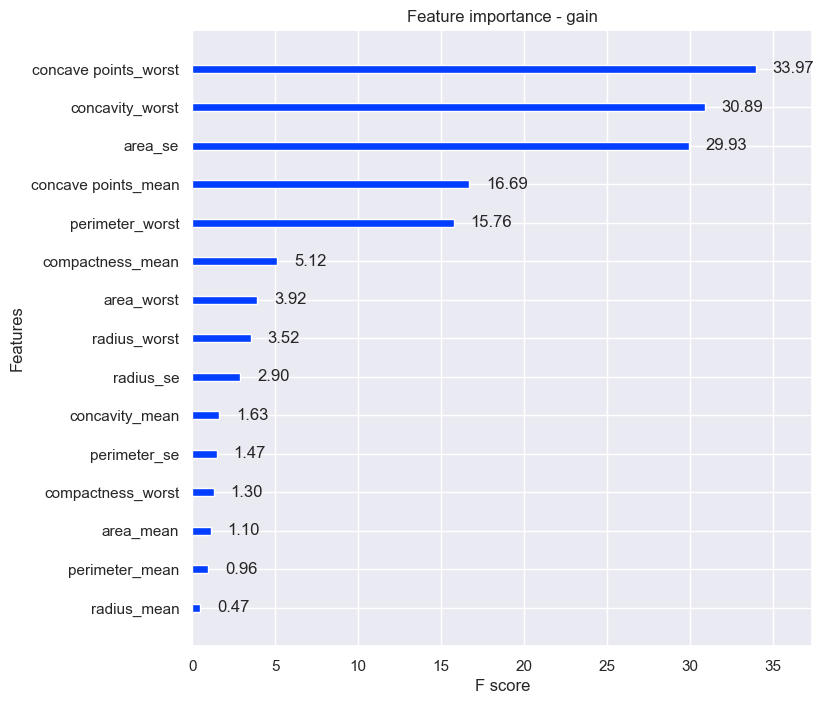

In [27]:
# Obter as importâncias das features
feature_importances_gain = grid_search.best_estimator_["clf"].get_booster().get_score(importance_type="gain")

# Ordenar as features por importância
sorted_features_gain = sorted(feature_importances.items(), key=lambda x: x[1])

# Extrair os índices ordenados
indices_ordenados_gain = [int(item[0].replace("f", "")) for item in sorted_features]

# Obter os nomes das features ordenadas
feature_names_gain = grid_search.best_estimator_["preprocessor"].get_feature_names_out()[indices_ordenados_weight]

# Plotar a importância das features
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    title="Feature importance - gain",
    values_format="{v:.2f}"
)

# Ajustar os rótulos do eixo y
plt.yticks(
    np.arange(len(feature_names_gain)),
    feature_names_gain
)

plt.show()

In [33]:
perm_imp = permutation_importance(
    grid_search.best_estimator_,
    X,
    y,
    n_repeats=10,
    random_state=RANDOM_STATE
)

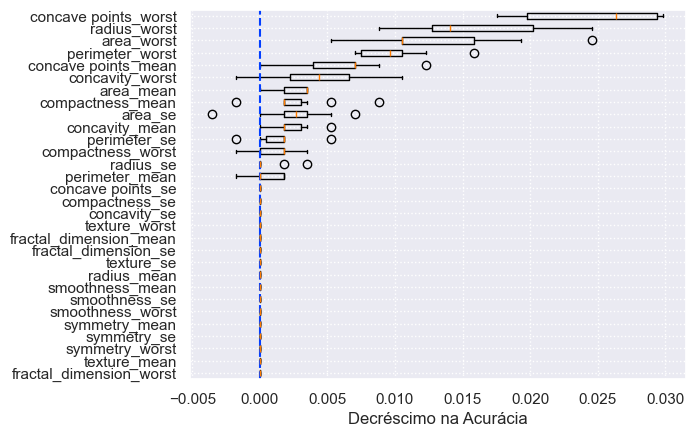

In [29]:
fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo na Acurácia")
ax.grid(True, linestyle=":")

plt.show()

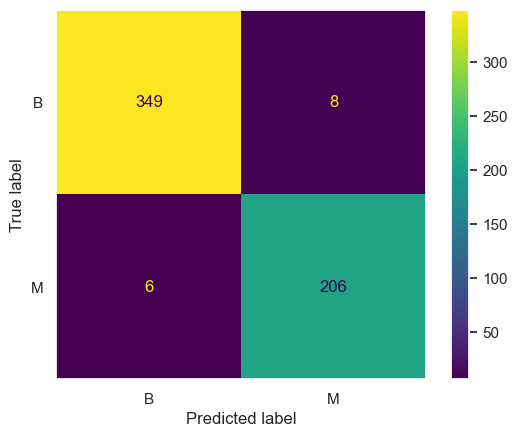

In [30]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
)
plt.grid(False)
plt.show()

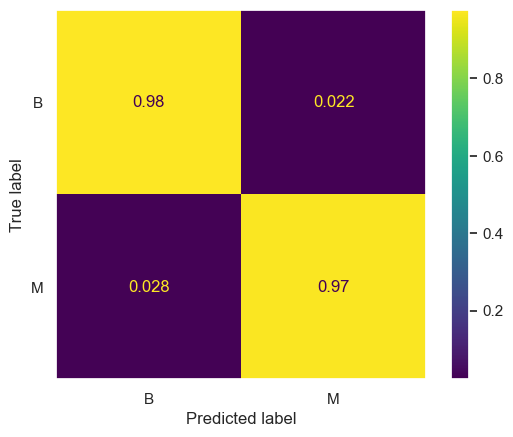

In [31]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize="true",
)
plt.grid(False)
plt.show()

### Conclusão

Comparação entre Modelos Lineares e Baseados em Árvores

Metodologia:

Pré-processamento diferenciado: Enquanto os modelos lineares utilizaram PowerTransformer, as árvores operaram com os dados originais (apenas seleção de features)

Seleção de Features: 15 features selecionadas por Mutual Information (consistente entre abordagens)

Métrica Primária: F2-score (priorizando recall para diagnóstico médico)

Resultados Principais:

Performance Comparada:

LogisticRegression obteve o melhor F2-score (0.931)

XGBClassifier foi a melhor árvore (F2-score: 0.915)

Todas as abordagens superaram significativamente o baseline (DummyClassifier: 0.398)

#### Principais Insights:

Modelos lineares mantiveram vantagem em velocidade e performance

XGBoost mostrou melhor equilíbrio entre acurácia (94.4%) e tempo de treino

A regularização nativa das árvores (parâmetros reg_alpha e reg_lambda) mostrou-se eficaz contra overfitting

Valores tão baixos no permutation_importance podem indicarfeatures altamente correlacionadas, ruídos em features ou redundância na informação preditiva. 

### Conclusion

Linear Models vs. Tree-Based Models Comparison

Methodology:

Differential preprocessing: Linear models used PowerTransformer while trees used raw data (only feature selection)

Feature Selection: 15 features selected via Mutual Information (consistent approach)

Primary Metric: F2-score (emphasizing recall for medical diagnosis)

Key Findings:

Performance Comparison:

LogisticRegression achieved the best F2-score (0.931)

XGBClassifier was the top tree-based model (F2-score: 0.915)

All approaches significantly outperformed baseline (DummyClassifier: 0.398)

Permutation Importance Analysis (XGBoost): 

    Low Values Interpretation
    
    Potential Causes: 
    
        Highly correlated features (e.g., radius_mean and perimeter_mean)

        Noise in less relevant features

        Predictive information redundancy

#### Key Insights:

Linear models maintained advantages in speed and performance

XGBoost showed the best balance between accuracy (94.4%) and training time

Native tree regularization (reg_alpha and reg_lambda) proved effective against overfitting

